### Importing All Necessary Dependencies

In [67]:
import openai
from openai import OpenAI

import numpy as np

import json

import matplotlib.pyplot as plt
from urllib.parse import urlparse
from itertools import combinations

import copy
import math

import requests
import random
import time

from scipy.spatial.distance import cosine
import gensim.downloader as api

from transformers import BertModel, BertTokenizer
import torch

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Establishing Access to OPEN AI API

In [4]:
client = OpenAI(api_key="sk-OPEN_AI_API_KEY")

### Setting up Word2Vec Model for Later Use

In [22]:
word2vec_model = api.load("word2vec-google-news-300")

### Setting up BERT Model for Later Use

In [30]:
model_name = "bert-base-uncased"  
bert_model = BertModel.from_pretrained(model_name)
bert_tokenizer = BertTokenizer.from_pretrained(model_name)

### Function to Convert Image to Large Text Description

*Function*

In [5]:
def image_to_text(image_url):

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": "Please provide a thorough, detailed, and artistic description of the image in the following URL: " + image_url + "Imagine you're painting a vivid picture with words, capturing every detail.",
            }
        ],
        max_tokens=500,
    )
    
    return response.choices[0].message.content

*Testing*

In [11]:
test_description = image_to_text("https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg")

print(test_description)

The scene opens onto a serene slice of nature amidst the bustle of Madison, Wisconsin. A wooden boardwalk, weathered yet sturdy, serves as the pathway inviting us further into this tranquil landscape. It meanders gently, curving toward a distant focal point, flanked by lush, dense tufts of tall, emerald green grass and other verdant plants that crowd close to its edges, almost spilling over onto the walkway.

On this clear day, the sky arches overhead, a vast expanse of an almost surreal, azure blue, speckled sporadically with soft, wispy clouds, whiter than snow. The sunlight is bright but gentle, casting a golden hue across the scene, highlighting the vibrant greens of the vegetation and lending the atmosphere an almost ethereal quality.

To the left of the boardwalk, a body of water lies still, mirroring the sky above with a precision that makes the surface appear more like glass than liquid. The reflections are a mesmerizing mix of blue and the verdant shades from the surrounding f

### Target Pre-defined Labels

*predefined labels list*

In [8]:
predefined_labels_list = {
        'Color Palette': ['Vibrant', 'Monochromatic', 'Pastel', 'Earthy', 'Neon', 'Muted', 'Bold'],
        'Subject Matter': ['Landscape', 'Portrait', 'Still life', 'Abstract', 'Urban', 'Nature', 'Architecture'],
        'Mood/Emotion': ['Serene', 'Energetic', 'Melancholic', 'Joyful', 'Mysterious', 'Peaceful', 'Dramatic'],
        'Style/Aesthetic': ['Realism', 'Impressionism', 'Surrealism', 'Minimalism', 'Expressionism', 'Cubism', 'Romanticism'],
        'Setting/Location': ['Cityscape', 'Countryside', 'Beach', 'Forest', 'Mountains', 'Urban', 'Rural'],
        'Time Period': ['Contemporary', 'Renaissance', 'Medieval', 'Modern', 'Ancient', 'Futuristic', 'Victorian'],
        'Cultural/Symbolic Representation': ['Religious', 'Political', 'Mythological', 'Historical', 'Indigenous', 'Pop culture', 'Folklore']
    }

*creating bert vocab for later use on these predefined labels*

In [32]:
bert_vocab = {}

# Generate BERT embeddings for each label
for attribute, labels in predefined_labels_list.items():
    for label in labels:
        # Tokenize the label
        inputs = bert_tokenizer(label, return_tensors="pt")
        
        # Pass tokenized sequence through BERT model to obtain embeddings
        with torch.no_grad():
            outputs = bert_model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Mean pooling of token embeddings
            
        # Store embeddings in bert_vocab dictionary
        bert_vocab[label] = embeddings

In [40]:
# Initialize dictionary to store BERT embeddings for each label
bert_vocab = {}

# Generate BERT embeddings for each label
for attribute, labels in predefined_labels_list.items():
    
    # tokenizing all the labels in labels list and passing them all together into BERT
    inputs = bert_tokenizer(labels, return_tensors="pt", padding=True, truncation=True)

    # Pass tokenized sequence through BERT model to obtain embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)
        # map each label to its corresponding embeddings in the output
        for i, label in enumerate(labels):
            embeddings = outputs.last_hidden_state[i].mean(dim=0).numpy()
            bert_vocab[label] = embeddings


*testing bert vocab*

In [41]:
print(bert_vocab['Vibrant'].shape)
print(bert_vocab['Landscape'].shape)
print(bert_vocab['Melancholic'].shape)
print(bert_vocab['Cubism'].shape)
print(bert_vocab['Cityscape'].shape)
print(bert_vocab['Ancient'].shape)
print(bert_vocab['Religious'].shape)

(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)


### Function to Convert Description of Image to Pre-Defined Labels

*Method to Troubleshoot Creation of non pre-defined labels when converting description to labels list*

In [7]:
def validate_attributes(attributes_dict, predefined_list):

    validated_attributes = {}

    for key, values in attributes_dict.items():
        valid_values = [value for value in values if value in predefined_list[key]]
        
        if len(valid_values) < len(values):
            missing_values = [value for value in predefined_list[key] if value not in valid_values]
            valid_values.extend(missing_values[:len(values)-len(valid_values)])
        
        validated_attributes[key] = valid_values
    
    return validated_attributes


*Method to convert description of an image to ordered predefined labels*

In [123]:
def description_to_all_attributes(description, predefined_input_list):

    predefined_list = copy.deepcopy(predefined_input_list)

    response = client.chat.completions.create(
        model = "gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": f"""
                You are a machine learning model trained to extract specific attributes from a detailed 
                description of an image. Your task is to identify and select the most appropriate label from 
                the following pre-defined set of attributes for each of the seven categories given below, and
                represent them as key-value pairs in a Python dictionary: 

                1. Color Palette: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Color Palette']}. 

                2. Subject Matter: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Subject Matter']}. 

                3. Mood/Emotion: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Mood/Emotion']}. 

                4. Style/Aesthetic: Select exactly 7 labels without repetition from ONLY the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Style/Aesthetic']}. 

                5. Setting/Location: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Setting/Location']}. 

                6. Time Period: Select exactly 7 labels without repetition from only the following options, 
                ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Time Period']}.

                7. Cultural/Symbolic Representation: Select Exactly 7 labels without repetition from only the 
                following options, ordered from the most closely associated to the least associated with the image: 
                {predefined_list['Cultural/Symbolic Representation']}

                Please provide your output in the following format:  
                {{'Color Palette': ['most associated label', ..., 'least associated label'],  
                'Subject Matter': ['most associated label', ..., 'least associated label'],  
                'Mood/Emotion': ['most associated label', ..., 'least associated label'], 
                'Style/Aesthetic': ['most associated label', ..., 'least associated label'],  
                'Setting/Location': ['most associated label', ..., 'least associated label'],  
                'Time Period': ['most associated label', ..., 'least associated label'],  
                'Cultural/Symbolic Representation': ['most associated label', ..., 'least associated label']}}. 

                If an attribute is not obvious, infer from the context of the description an attribute, 
                don't use 'none' or 'not specified' as an attribute. Remember, you MUST ONLY select attribute values from the provided
                list of options. DO NOT assign any attribute that is not present in the pre-defined attributes. I repeat - no label in the result should be outside the predefined 
                set of labels for each attribute. Format the output in double quotations so it can be 
                converted into an object with json. The description is as follows:""" + description
            }
        ],
        max_tokens=500,
    )

    attributes_content = response.choices[0].message.content
    print(attributes_content)

    # Remove leading and trailing whitespace
    json_data = attributes_content.strip()

    attributes_dict = json.loads(json_data)
    
    validated_attributes_dict = validate_attributes(attributes_dict, predefined_list)

    return validated_attributes_dict

*Testing the description to all attributes function*

In [15]:
obj = description_to_all_attributes(test_description, predefined_labels_list)
print(json.dumps(obj, indent=4))

# print the length of the array for each attribute in the object

for key, value in obj.items():
    print(key, len(value))

{
    "Color Palette": [
        "Vibrant",
        "Earthy",
        "Muted",
        "Pastel",
        "Bold",
        "Monochromatic",
        "Neon"
    ],
    "Subject Matter": [
        "Landscape",
        "Nature",
        "Still life",
        "Abstract",
        "Portrait",
        "Urban",
        "Architecture"
    ],
    "Mood/Emotion": [
        "Serene",
        "Peaceful",
        "Joyful",
        "Mysterious",
        "Energetic",
        "Melancholic",
        "Dramatic"
    ],
    "Style/Aesthetic": [
        "Realism",
        "Impressionism",
        "Romanticism",
        "Expressionism",
        "Surrealism",
        "Minimalism",
        "Cubism"
    ],
    "Setting/Location": [
        "Countryside",
        "Forest",
        "Beach",
        "Mountains",
        "Cityscape",
        "Urban",
        "Rural"
    ],
    "Time Period": [
        "Contemporary",
        "Modern",
        "Victorian",
        "Renaissance",
        "Medieval",
        "Ancient",
 

### Metric Based Comparison Functions for comparing labels for a single attribute

*Manhattan Distance - Absolute Distance between indices*

In [16]:
def manhattan_discimilarity(arr1, arr2):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    # Calculate the sum of absolute distances
    total_distance = 0

    for i, element in enumerate(arr1):

        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance = abs(i - index_in_array2)
            total_distance += distance
        else: 
            print(f"Warning '{element}' not found in .")

    return total_distance

*Eucladian Distance - Square of Absolute Distance between indices*

In [17]:
def eucladian_discimilarity(arr1, arr2):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    # Calculate the sum of absolute distances
    total_distance = 0

    for i, element in enumerate(arr1):

        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance = abs(i - index_in_array2)
            total_distance += distance ** 2
        else: 
            print(f"Warning '{element}' not found in .")

    return total_distance

*Modified Manhattan Distance - taking into consideration the indices for only 1 list*

In [20]:
def modified_manhattan_discimilarity(arr1, arr2):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    # Calculate the sum of absolute distances
    total_distance = 0

    for i, element in enumerate(arr1):

        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance = abs(i - index_in_array2) 
            weighted_distance = distance / math.log2(i + 2)
            total_distance += weighted_distance
        else: 
            print(f"Warning '{element}' not found in .")

    return total_distance

*Word2Vec Based Dissimilairty Function*

In [54]:
def word2vec_discimilarity(arr1, arr2, manhattan_weight=1.0, cosine_weight=0.5):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    total_distance_manhattan = 0
    total_distance_cosine = 0

    for i, element in enumerate(arr1):
        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance1 = abs(i - index_in_array2)
            total_distance_manhattan += distance1
        else: 
            print(f"Warning '{element}' not found in arr2.")

    for i, element in enumerate(arr1):
        parallel_element = arr2[i]
        if element in word2vec_model and parallel_element in word2vec_model:
            word1_embedding = word2vec_model[element]
            word2_embedding = word2vec_model[parallel_element]
            cosine_similarity = 1 - cosine(word1_embedding, word2_embedding)
            total_distance_cosine += cosine_similarity
        else:
            print(f"Warning: '{element}' or '{parallel_element}' not found in Word2Vec model vocabulary.")
    
    # Scale the Manhattan distance and cosine distance with the respective weights
    scaled_manhattan_distance = manhattan_weight * total_distance_manhattan
    scaled_cosine_distance = cosine_weight * total_distance_cosine

    # Calculate the total distance as a combination of the scaled distances
    total_distance = scaled_manhattan_distance + scaled_cosine_distance

    return total_distance


*BERT Based Dissimilarity Function*

In [42]:
def bert_discimilarity(arr1, arr2, manhattan_weight=1.0, cosine_weight=0.5):
    
    index_dict = {element: i for i, element in enumerate(arr2)}

    total_distance_manhattan = 0
    total_distance_cosine = 0

    for i, element in enumerate(arr1):
        if element in index_dict:
            index_in_array2 = index_dict[element]
            distance1 = abs(i - index_in_array2)
            total_distance_manhattan += distance1
        else: 
            print(f"Warning '{element}' not found in arr2.")

    for i, element in enumerate(arr1):
        parallel_element = arr2[i]
        if element in bert_vocab and parallel_element in bert_vocab:
            word1_embedding = bert_vocab[element]
            word2_embedding = bert_vocab[parallel_element]
            cosine_similarity = 1 - cosine(word1_embedding, word2_embedding)
            total_distance_cosine += cosine_similarity
        else:
            print(f"Warning: '{element}' or '{parallel_element}' not found in Word2Vec model vocabulary.")
    
    # Scale the Manhattan distance and cosine distance with the respective weights
    scaled_manhattan_distance = manhattan_weight * total_distance_manhattan
    scaled_cosine_distance = cosine_weight * total_distance_cosine

    # Calculate the total distance as a combination of the scaled distances
    total_distance = scaled_manhattan_distance + scaled_cosine_distance

    return total_distance


### Functions to Compare all Labels and Specific Labels for Images

*function to calcuate total similarity across all attributes*

In [47]:
def calculate_total_similarity(attributes_image_1, attributes_image_2, metric="word2vec", manhattan_weight=1.0, cosine_weight=0.5):
    
    # Initialize the total similarity score
    total_similarity = 0
    
    # Calculate the similarity score for each attribute
    for attribute1, value1 in attributes_image_1.items():
        
        value2 = attributes_image_2[attribute1]
        
        if metric == "word2vec":
            similarity_score = word2vec_discimilarity(value1, value2, manhattan_weight, cosine_weight)
        elif metric == "bert":
            similarity_score = bert_discimilarity(value1, value2, manhattan_weight, cosine_weight)
        elif metric == "manhattan":
            similarity_score = manhattan_discimilarity(value1, value2)
        elif metric == "eucladian":
            similarity_score = eucladian_discimilarity(value1, value2)
        elif metric == "modified_manhattan":
            similarity_score = modified_manhattan_discimilarity(value1, value2)
        else:
            print("Invalid model name. Please choose either 'word2vec' or 'bert'.")
            return None
        
        total_similarity += similarity_score
    
    return total_similarity

*function to calculate similairty across specific attribute*

In [102]:
def calculate_label_dissimilarity(attributes_image_1, attributes_image_2, label, metric="word2vec", manhattan_weight=1.0, cosine_weight=0.5):

    similarity_score = 0
    
    value1 = attributes_image_1.get(label)
    value2 = attributes_image_2.get(label)

    if metric == "word2vec":
        similarity_score = word2vec_discimilarity(value1, value2, manhattan_weight, cosine_weight)
    elif metric == "bert":
        similarity_score = bert_discimilarity(value1, value2, manhattan_weight, cosine_weight)
    elif metric == "manhattan":
        similarity_score = manhattan_discimilarity(value1, value2)
    elif metric == "eucladian":
        similarity_score = eucladian_discimilarity(value1, value2)
    elif metric == "modified_manhattan":
        similarity_score = modified_manhattan_discimilarity(value1, value2)
    else:
        print("Invalid model name. Please choose either 'word2vec' or 'bert'.")
        return None
    
    return similarity_score

### Testing our various metric systems on Generic Example

*Creating list attributes for 3 images*

In [46]:
art_url_1 = "https://upload.wikimedia.org/wikipedia/commons/0/0d/Great_Wave_off_Kanagawa2.jpg"
art_url_2 = "https://upload.wikimedia.org/wikipedia/commons/9/94/The_Nightwatch_by_Rembrandt_-_Rijksmuseum.jpg"
art_url_3 = "https://upload.wikimedia.org/wikipedia/commons/b/b6/Sebastiano_Ricci_002.jpg"

text_1 = image_to_text(art_url_1)
attributes_1 = description_to_all_attributes(text_1, predefined_labels_list)

text_2 = image_to_text(art_url_2)
attributes_2 = description_to_all_attributes(text_2, predefined_labels_list)

text_3 = image_to_text(art_url_3)
attributes_3 = description_to_all_attributes(text_3, predefined_labels_list)

In [49]:
print(json.dumps(attributes_1, indent=4))
print(json.dumps(attributes_2, indent=4))
print(json.dumps(attributes_3, indent=4))

{
    "Color Palette": [
        "Bold",
        "Vibrant",
        "Muted",
        "Monochromatic",
        "Earthy",
        "Pastel",
        "Neon"
    ],
    "Subject Matter": [
        "Nature",
        "Abstract",
        "Landscape",
        "Portrait",
        "Still life",
        "Urban",
        "Architecture"
    ],
    "Mood/Emotion": [
        "Dramatic",
        "Peaceful",
        "Mysterious",
        "Serene",
        "Energetic",
        "Melancholic",
        "Joyful"
    ],
    "Style/Aesthetic": [
        "Realism",
        "Impressionism",
        "Surrealism",
        "Romanticism",
        "Expressionism",
        "Minimalism",
        "Cubism"
    ],
    "Setting/Location": [
        "Beach",
        "Mountains",
        "Forest",
        "Countryside",
        "Cityscape",
        "Rural",
        "Urban"
    ],
    "Time Period": [
        "Modern",
        "Contemporary",
        "Ancient",
        "Medieval",
        "Renaissance",
        "Futuristic",


*testing various dissimilairty functions on the 3 attributes*

In [48]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "manhattan")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "manhattan")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "manhattan")

print("Manhattan Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Manhattan Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Manhattan Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Manhattan Disimilarity between Art URL 1 and Art URL 2: 106
Manhattan Disimilarity between Art URL 1 and Art URL 3: 64
Manhattan Disimilarity between Art URL 2 and Art URL 3: 104


In [50]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "eucladian")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "eucladian")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "eucladian")

print("Eucladian Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Eucladian Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Eucladian Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Eucladian Disimilarity between Art URL 1 and Art URL 2: 340
Eucladian Disimilarity between Art URL 1 and Art URL 3: 172
Eucladian Disimilarity between Art URL 2 and Art URL 3: 344


In [51]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "modified_manhattan")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "modified_manhattan")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "modified_manhattan")

print("Modified Manhattan Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Modified Manhattan Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Modified Manhattan Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Modified Manhattan Disimilarity between Art URL 1 and Art URL 2: 54.91617957263931
Modified Manhattan Disimilarity between Art URL 1 and Art URL 3: 35.24236646134862
Modified Manhattan Disimilarity between Art URL 2 and Art URL 3: 52.641385268356956


In [55]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "word2vec")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "word2vec")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "word2vec")

print("Word2Vec Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Word2Vec Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Word2Vec Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Word2Vec Disimilarity between Art URL 1 and Art URL 2: 115.85569156195116
Word2Vec Disimilarity between Art URL 1 and Art URL 3: 76.80501157543127
Word2Vec Disimilarity between Art URL 2 and Art URL 3: 114.64557622699982


In [56]:
dis_art1_art2 = calculate_total_similarity(attributes_1, attributes_2, "bert")
dis_art1_art3 = calculate_total_similarity(attributes_1, attributes_3, "bert")
dis_art2_art3 = calculate_total_similarity(attributes_2, attributes_3, "bert")

print("Bert Disimilarity between Art URL 1 and Art URL 2:", dis_art1_art2)
print("Bert Disimilarity between Art URL 1 and Art URL 3:", dis_art1_art3)
print("Bert Disimilarity between Art URL 2 and Art URL 3:", dis_art2_art3)

Bert Disimilarity between Art URL 1 and Art URL 2: 124.93912362750332
Bert Disimilarity between Art URL 1 and Art URL 3: 84.38904585600166
Bert Disimilarity between Art URL 2 and Art URL 3: 123.02547662086326


### Function to Load N Random Art Images from WikiArt

*Trouble Shooting URL Checking Function*

In [57]:
def is_url_valid(url):
    """
    Check if a URL returns a 200 (OK) status code.
    """
    response = requests.head(url)
    return response.status_code == 200

*function to randomly pull n image urls*

In [119]:
def get_images():

   # Define the base URL for the WikiArt API
    base_url = "https://www.wikiart.org/en/App/Painting/MostViewedPaintings"


    # Define the parameters for the API request
    params = {
        "randomSeed": int(time.time()),
        "json": 2,
        "inPublicDomain": True,
    }

    # Send a GET request to the WikiArt API
    response = requests.get(base_url, params=params)

    # Check that the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract a small sample of art image URLs
        sample_size = 6  # Change this to the number of samples you want
        
        # URLs
        image_urls = []

        # Randomly select paintings from the data list
        for painting in random.sample(data, sample_size):
            # Check if the image URL is valid
            if is_url_valid(painting["image"]):
                # If the URL is valid, add it to the list
                image_urls.append(painting["image"])


        # Shuffle the list of image URLs
        random.shuffle(image_urls)

        # Now you can use the image_urls list in your OpenAI API call
    else:
        print(f"Failed to get data from WikiArt API: {response.status_code}")


    # Create a dictionary of URLs with their corresponding names
    url_dict = {urlparse(url).path.split('/')[-1].split('.')[0]: url for url in image_urls}
    
    return url_dict

*testing this function to pull 10 random image urls*

In [59]:
image_urls = get_images()
print(image_urls)

{'light-of-iris': 'https://uploads1.wikiart.org/images/georgia-o-keeffe/light-of-iris.jpg!Large.jpg', 'the-bather-1879': 'https://uploads4.wikiart.org/images/william-adolphe-bouguereau/the-bather-1879.jpg!Large.jpg', 'house-of-parliament-sun': 'https://uploads7.wikiart.org/images/claude-monet/house-of-parliament-sun.jpg!Large.jpg', 'emerald': 'https://uploads2.wikiart.org/images/alphonse-mucha/emerald.jpg!Large.jpg', 'the-disintegration-of-the-persistence-of-memory': 'https://uploads5.wikiart.org/images/salvador-dali/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg', 'girl-in-front-of-mirror-1932': 'https://uploads4.wikiart.org/images/pablo-picasso/girl-in-front-of-mirror-1932.jpg!Large.jpg', 'galatea-detail-of-mermen-and-dolphins-1506': 'https://uploads3.wikiart.org/images/raphael/galatea-detail-of-mermen-and-dolphins-1506.jpg!Large.jpg', 'hygeia-detail-of-medicine-1907': 'https://uploads5.wikiart.org/images/gustav-klimt/hygeia-detail-of-medicine-1907.jpg!Large.jpg', 'sum

### Comparing Image from their URLS 

*function to calculate total similarity between images given the urls*

In [63]:
def compare_images_total_similarity(images):

    print('images: ', json.dumps(image_urls, indent=4))

    image_description_labels = {}

    for image_name, image_url in image_urls.items():
        description = image_to_text(image_url)
        attributes = description_to_all_attributes(description, predefined_labels_list)
        image_description_labels[image_name] = attributes

    comparisons = []
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference = calculate_total_similarity(image_description_labels[image1], image_description_labels[image2], "bert")
        comparisons.append((f"{image1} vs {image2}", difference))

    return comparisons

*testing the comparisons result of the above function*

In [64]:
comparisons = compare_images_total_similarity(image_urls)
print(comparisons)

images:  {
    "light-of-iris": "https://uploads1.wikiart.org/images/georgia-o-keeffe/light-of-iris.jpg!Large.jpg",
    "the-bather-1879": "https://uploads4.wikiart.org/images/william-adolphe-bouguereau/the-bather-1879.jpg!Large.jpg",
    "house-of-parliament-sun": "https://uploads7.wikiart.org/images/claude-monet/house-of-parliament-sun.jpg!Large.jpg",
    "emerald": "https://uploads2.wikiart.org/images/alphonse-mucha/emerald.jpg!Large.jpg",
    "the-disintegration-of-the-persistence-of-memory": "https://uploads5.wikiart.org/images/salvador-dali/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg",
    "girl-in-front-of-mirror-1932": "https://uploads4.wikiart.org/images/pablo-picasso/girl-in-front-of-mirror-1932.jpg!Large.jpg",
    "galatea-detail-of-mermen-and-dolphins-1506": "https://uploads3.wikiart.org/images/raphael/galatea-detail-of-mermen-and-dolphins-1506.jpg!Large.jpg",
    "hygeia-detail-of-medicine-1907": "https://uploads5.wikiart.org/images/gustav-klimt/hygeia-de

In [87]:
new_comparisons = []

for comparison in comparisons:
    # seperate the first image name and the second image name
    image1, image2 = comparison[0].split(' vs ')
    # create a new key with the two image names based on their indices in the image_urls dictionary
    new_key = f"{list(image_urls.keys()).index(image1) + 1} vs {list(image_urls.keys()).index(image2) + 1}"
    new_comparisons.append((new_key, comparison[1]))

print(len(new_comparisons))
print(json.dumps(new_comparisons, indent=4))

45
[
    [
        "1 vs 2",
        73.77305420685259
    ],
    [
        "1 vs 3",
        105.04209118589634
    ],
    [
        "1 vs 4",
        81.4376242680697
    ],
    [
        "1 vs 5",
        79.83945222987559
    ],
    [
        "1 vs 6",
        101.3704868002971
    ],
    [
        "1 vs 7",
        108.87752155187951
    ],
    [
        "1 vs 8",
        86.49232136686655
    ],
    [
        "1 vs 9",
        111.3559309418354
    ],
    [
        "1 vs 10",
        108.82223462490998
    ],
    [
        "2 vs 3",
        103.40320013989712
    ],
    [
        "2 vs 4",
        47.637255639868386
    ],
    [
        "2 vs 5",
        107.49546265318082
    ],
    [
        "2 vs 6",
        115.69291616954432
    ],
    [
        "2 vs 7",
        109.53951131185386
    ],
    [
        "2 vs 8",
        91.80243764705402
    ],
    [
        "2 vs 9",
        73.14196061983442
    ],
    [
        "2 vs 10",
        110.8547661755325
    ],
    [
        "3 

### Implementing K-Means Clustering on our Comparisons to Visualize Them

In [100]:
def visualize_comparisons(comparisons):
    # Extract the image names and differences from the comparisons
    image_pairs = [comparison[0] for comparison in comparisons]
    differences = [comparison[1] for comparison in comparisons]

    # Reshape differences for KMeans clustering
    differences_array = [[diff] for diff in differences]

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=1)
    kmeans.fit(differences_array)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Plot the differences
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(differences)), differences, c=labels, cmap='viridis', alpha=0.5)
    plt.scatter(range(len(centroids)), centroids, marker='x', color='red')

    # Draw horizontal lines passing through each centroid
    for centroid in centroids:
        plt.axhline(y=centroid, color='gray', linestyle='--')

    # Annotate points with image comparison labels
    for i, (pair, diff) in enumerate(zip(image_pairs, differences)):
        plt.annotate(pair, (i, diff), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=6)  # Adjust fontsize here

    plt.title('Image Comparisons')
    plt.xlabel('Comparison Index')
    plt.ylabel('Difference')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()

    print("Centroids:", centroids)


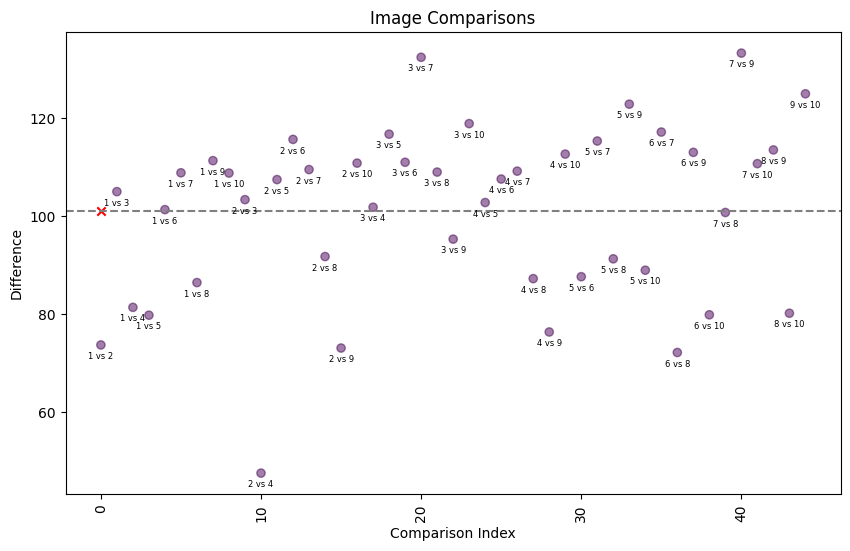

Centroids: [[101.11705684]]


In [101]:
visualize_comparisons(new_comparisons)

*The above graph quantifies the similarity amongst all the images in our dataset. The line passing through the centroid represents the average similarity between any two arbitrary images in our dataset. Images below this threshold show more similarity while Images above this threshold show higher similarity*

*function to determine comparison for a specific label*

In [120]:
image_urls_2 = get_images()
print(image_urls_2)

{'portrait-of-ginevra-benci': 'https://uploads5.wikiart.org/images/leonardo-da-vinci/portrait-of-ginevra-benci.jpg!Large.jpg', 'the-barefoot-girl-1895': 'https://uploads7.wikiart.org/images/pablo-picasso/the-barefoot-girl-1895.jpg!Large.jpg', 'branches-with-almond-blossom-1890(1)': 'https://uploads6.wikiart.org/images/vincent-van-gogh/branches-with-almond-blossom-1890(1).jpg!Large.jpg', 'poison-oasis': 'https://uploads4.wikiart.org/images/jean-michel-basquiat/poison-oasis.jpg!Large.jpg', 'the-scream-1893(2)': 'https://uploads2.wikiart.org/images/edvard-munch/the-scream-1893(2).jpg!Large.jpg', 'girl-on-the-ball-1905': 'https://uploads6.wikiart.org/images/pablo-picasso/girl-on-the-ball-1905.jpg!Large.jpg'}


In [121]:
def compare_images_label_similarity(images, label):

    print('images: ', json.dumps(image_urls_2, indent=4))

    image_description_labels = {}
    i = 0

    for image_name, image_url in image_urls_2.items():
        description = image_to_text(image_url)
        attributes = description_to_all_attributes(description, predefined_labels_list)
        image_description_labels[image_name] = attributes
        i += 1
        print(i)

    comparisons = []
    for image1, image2 in combinations(image_description_labels.keys(), 2):
        difference = calculate_label_dissimilarity(image_description_labels[image1], image_description_labels[image2], label, "bert")
        comparisons.append((f"{image1} vs {image2}", difference))

    return comparisons

In [124]:
label_comparison = compare_images_label_similarity(image_urls_2, "Color Palette")
print(label_comparison)

images:  {
    "portrait-of-ginevra-benci": "https://uploads5.wikiart.org/images/leonardo-da-vinci/portrait-of-ginevra-benci.jpg!Large.jpg",
    "the-barefoot-girl-1895": "https://uploads7.wikiart.org/images/pablo-picasso/the-barefoot-girl-1895.jpg!Large.jpg",
    "branches-with-almond-blossom-1890(1)": "https://uploads6.wikiart.org/images/vincent-van-gogh/branches-with-almond-blossom-1890(1).jpg!Large.jpg",
    "poison-oasis": "https://uploads4.wikiart.org/images/jean-michel-basquiat/poison-oasis.jpg!Large.jpg",
    "the-scream-1893(2)": "https://uploads2.wikiart.org/images/edvard-munch/the-scream-1893(2).jpg!Large.jpg",
    "girl-on-the-ball-1905": "https://uploads6.wikiart.org/images/pablo-picasso/girl-on-the-ball-1905.jpg!Large.jpg"
}
{
    "Color Palette": ["Muted", "Earthy", "Pastel", "Monochromatic", "Vibrant", "Bold", "Neon"],
    "Subject Matter": ["Portrait", "Abstract", "Nature", "Landscape", "Still life", "Urban", "Architecture"],
    "Mood/Emotion": ["Serene", "Mysterious"

In [128]:
new_label_comparisons = []

for comparison in label_comparison:
    # seperate the first image name and the second image name
    image1, image2 = comparison[0].split(' vs ')
    # create a new key with the two image names based on their indices in the image_urls dictionary
    new_key = f"{list(image_urls_2.keys()).index(image1) + 1} vs {list(image_urls_2.keys()).index(image2) + 1}"
    new_label_comparisons.append((new_key, comparison[1]))

print(len(new_label_comparisons))
print(json.dumps(new_label_comparisons, indent=4))

15
[
    [
        "1 vs 2",
        5.039948288106981
    ],
    [
        "1 vs 3",
        16.33697201343942
    ],
    [
        "1 vs 4",
        22.4025930417305
    ],
    [
        "1 vs 5",
        18.52097760749216
    ],
    [
        "1 vs 6",
        6.681499338991745
    ],
    [
        "2 vs 3",
        16.164678486940403
    ],
    [
        "2 vs 4",
        22.472820653270475
    ],
    [
        "2 vs 5",
        18.450749995952187
    ],
    [
        "2 vs 6",
        8.456697018248079
    ],
    [
        "3 vs 4",
        14.2463500053261
    ],
    [
        "3 vs 5",
        10.602776468663833
    ],
    [
        "3 vs 6",
        12.752317372890118
    ],
    [
        "4 vs 5",
        8.656505277335334
    ],
    [
        "4 vs 6",
        22.008557435147786
    ],
    [
        "5 vs 6",
        18.30610272612793
    ]
]


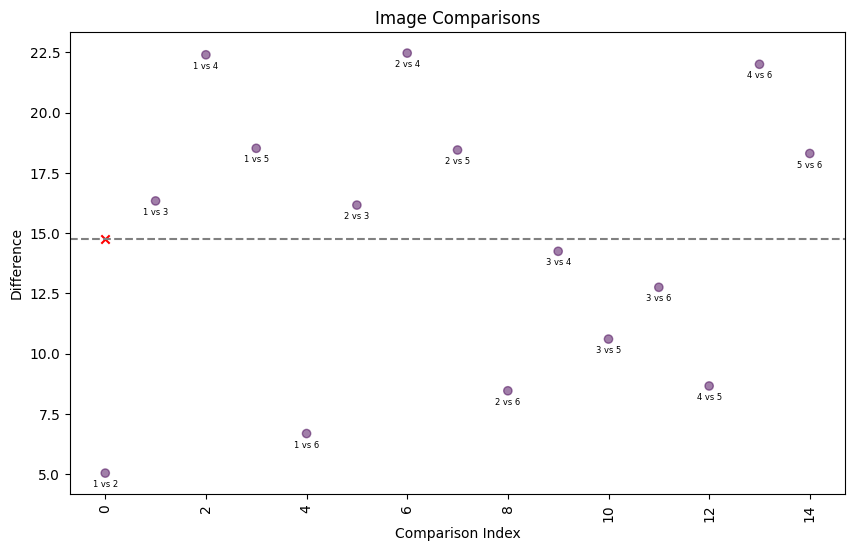

Centroids: [[14.73996972]]


In [129]:
visualize_comparisons(new_label_comparisons)